# Классификация с помощью kNN. Кластеризация K-means

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

In [ ]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy as sc

In [ ]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

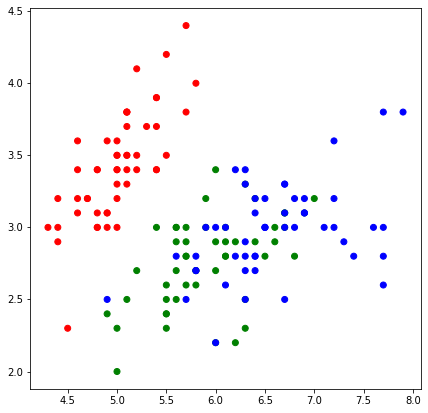

In [ ]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [ ]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

Задаим три варианта работы алгоритма, классический, с учётом дистанции и с учётом ранга в отсортированном массиве. Для рассчёта ранга используем библиотечную функцию, чтобы у равных объектов были равне ранги. Можно использовать только номер, но тогда объекты будут иметь разные ранги не смотря на нахождение рядом. 

In [ ]:
def knn(x_train, y_train, x_test, k, type='clear'):
    # clear,  # dist, # ranking
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        if type=='clear':
            for d in sorted(test_distances)[0:k]:
                classes[d[1]] += 1
        elif type=='dist':
            s_dist = sorted(test_distances)[0:k]
            for d in s_dist:
                dist, c = d
                classes[c] += (1/(dist+1e-10))
        elif type=='ranking':
            i = 0
            for d in sorted(test_distances)[0:k]:
                _, c = d
                classes[c] += (1/(i+1e-10))
                i+=1
                

            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [ ]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Построим график распределения классов.

In [ ]:
def get_graph(X_train, y_train, k, crit):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, crit)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k} режим {crit}")
    plt.show()

Построим графики для метода с использованием дистанции с разными `k`

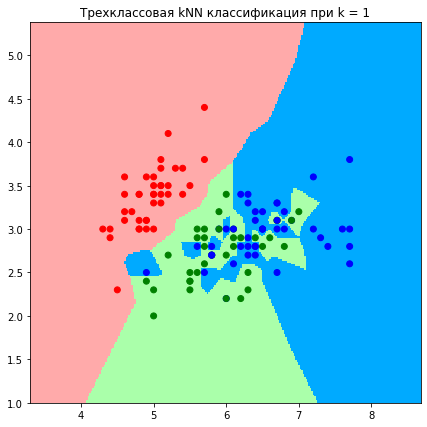

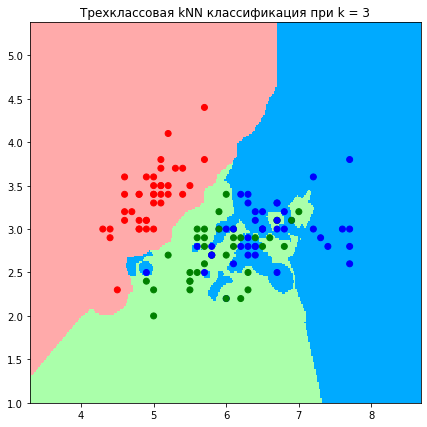

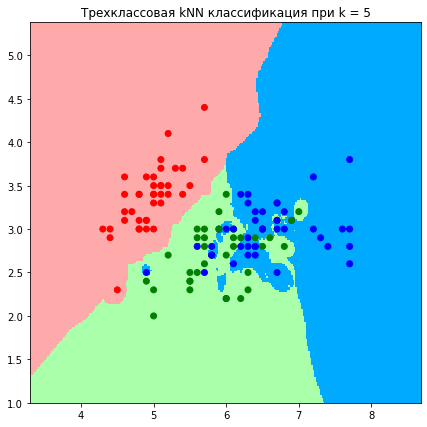

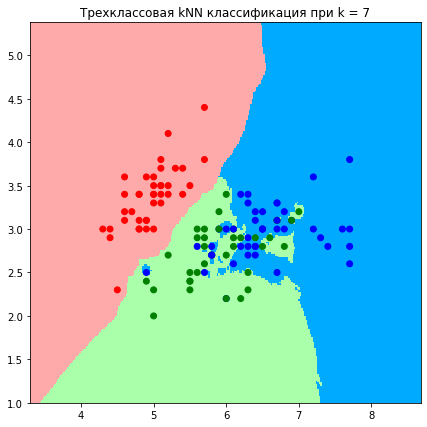

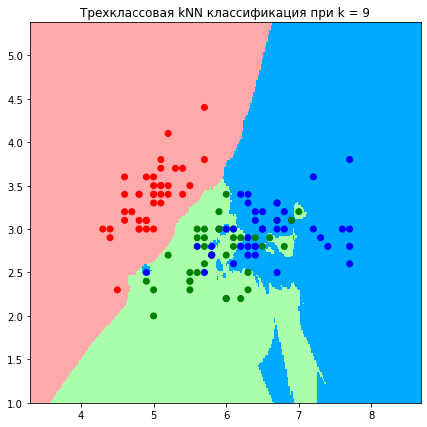

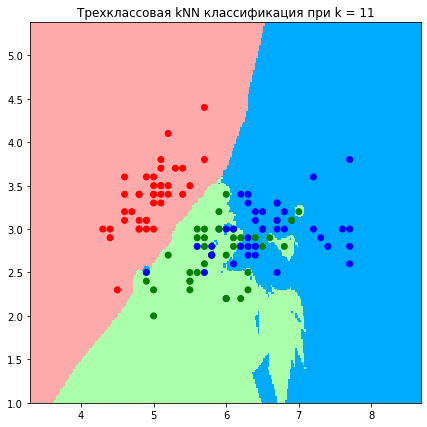

In [ ]:
max = 6
for i in range(1, max*2, 2):
  get_graph(X_train, y_train, i, 'dist')


Построим методы для разного ранга с разными `k`

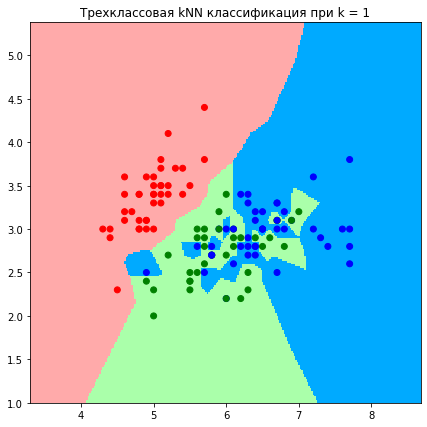

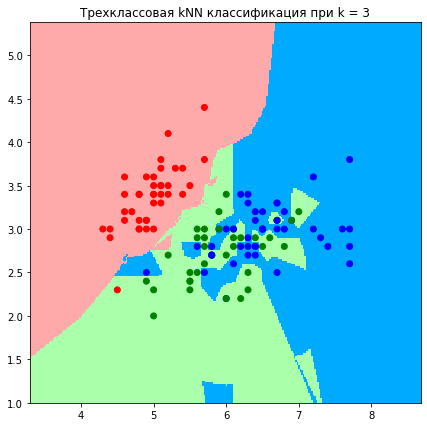

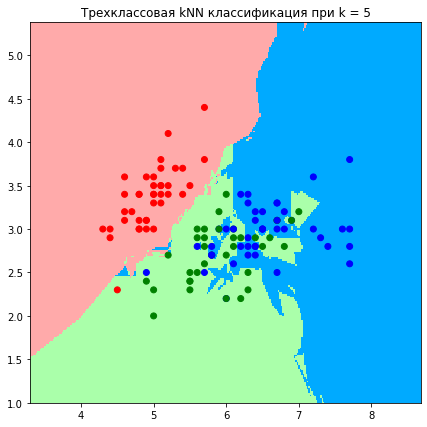

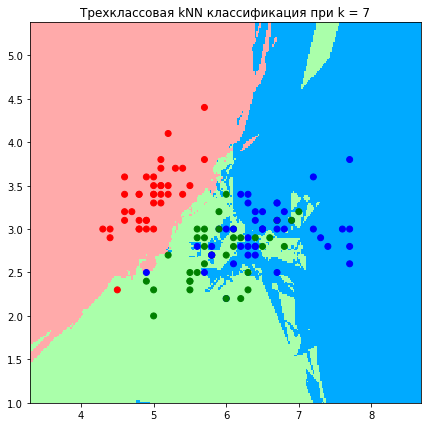

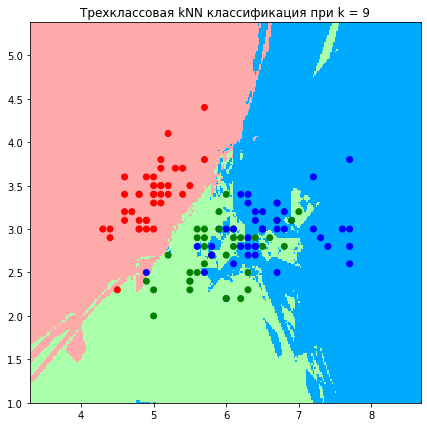

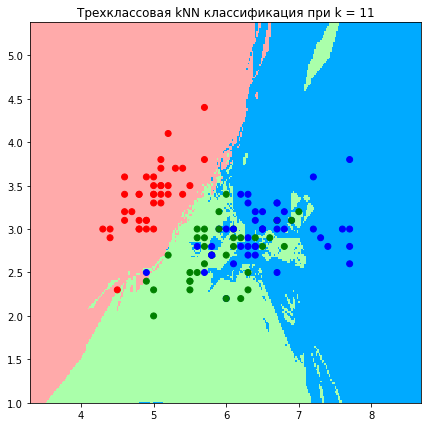

In [ ]:
max = 6
for i in range(1, max*2, 2):
  get_graph(X_train, y_train, i, 'ranking')

# Выводы
Оптимальное количество `k` ближайших соседей наоходится в районе 5-7. Сначала с ростом `k` гиперплоскость становится лучше, затем начинается переобучение и она опять портится. 

Кажется что работать по дистанции точнее, чем по рангу.